In [2]:
# %%
# %%
import os
import sys
import numpy as np
import torch
# from torch.utils.data import TensorDataset, DataLoader

# DL-Kit
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/dl-kit') #TODO adjust path
sys.path.append('/projects/ecrpstats/dl-kit') #TODO adjust path
from dlkit.log.log_util import (logging_set_up, logging_get_logger)
# from dlkit.nets.mlp import MLPModel
from dlkit.opt.train import train_epochs
from dlkit.nets.conv2d import Conv2dUpscaleModelInterpolate

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading
import plotting

import matplotlib.pyplot as plt

import pandas as pd


train_or_load = 'load'
# %%
hr_data_size = 64
lr_data_size = 8
# %%
epochs = 300
batch_size = 32
##
num_sing_mode = 50
##
region = 0
subregion = 'all'

log_file_base_path = 'parCov_fitting'

save_path = f'{log_file_base_path}.pt'

## ~~~~~~~~~~~
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.75, 
    order='(subregion, time)'
    ) 

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using device: {device}")

Using device: cpu


Define basis functions

In [4]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

In [5]:
x = np.arange(0, N)

xg = np.tile(x, N)            # generates x-coordinates for the entire grid N*K 
yg = np.repeat(x, N, axis=0)

mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

In [6]:
## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

In [7]:
## Generate complex tensor
basis_functions_tensor = torch.tensor(basis_functions, dtype=torch.complex64).to(device)

In [8]:
basis_functions_tensor.shape

torch.Size([4096, 1089])

In [9]:
basis_functions_tensor.unsqueeze(0).shape

torch.Size([1, 4096, 1089])

# Fit global covariance with MSE start 

In [10]:
try:
    test_mse_error_fields = np.load("../stage_1/mse_5l_i123_c32s_padR_schLrG0p95_reg0_errFields.npy")
    train_mse_error_fields = np.load("../stage_1/mse_5l_i123_c32s_padR_schLrG0p95_reg0_TrainErrFields.npy")
except:
    pass

# %%
test_mse_error_fields.shape

# %%
train_mse_error_fields.shape

# %%
mse_error_fields = np.concatenate((train_mse_error_fields, test_mse_error_fields), axis=0)


# Analytical solution to stage-2

$s_i = (\phi^\dagger Y^T Y \phi)_{ii}$

In [11]:
mse_error_fields.shape

(856, 64, 64)

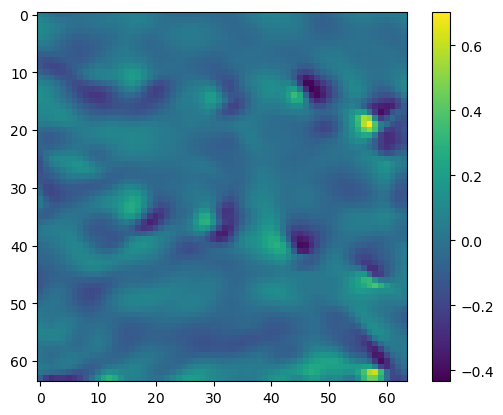

In [12]:
plt.imshow(mse_error_fields[0])
plt.colorbar()

In [13]:
basis_functions.shape

(4096, 1089)

In [14]:
mse_error_fields.shape

(856, 64, 64)

In [15]:
img_0_A = np.conj(basis_functions.T/N) @ mse_error_fields[0].ravel()[:, None] @ mse_error_fields[0].ravel()[None, :] @ basis_functions/N

In [16]:
np.diag(img_0_A)

array([1.12390675e+00+0.00000000e+00j, 3.64592948e-02-3.46944695e-18j,
       1.67760079e-02+1.34441069e-16j, ...,
       6.91341902e-07+5.87629107e-21j, 5.91284386e-07+6.35274710e-22j,
       1.30428504e-06-1.36741026e-32j])

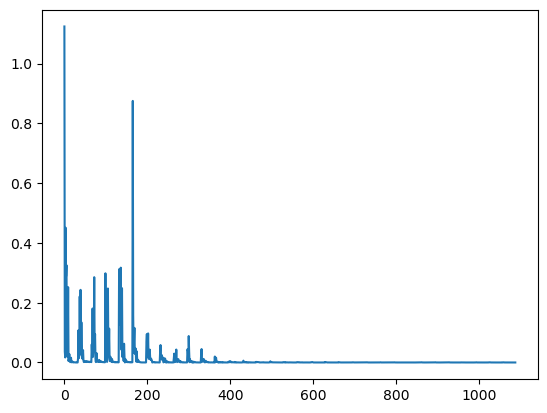

In [17]:
plt.plot(np.real(np.diag(img_0_A)))

In [18]:
img_spec_anal_params = np.zeros((mse_error_fields.shape[0], 1089))

for i in range(mse_error_fields.shape[0]):
    img_spec_anal_params[i] = np.diag(
        np.conj(basis_functions.T/N) 
        @ mse_error_fields[i].ravel()[:, None] 
        @ mse_error_fields[i].ravel()[None, :] 
        @ basis_functions/N
    )

/var/folders/k5/f6wjdcgd45n9wdxqb2g5v86m8nrvk5/T/ipykernel_80721/461754341.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  img_spec_anal_params[i] = np.diag(


In [19]:
img_spec_anal_params

array([[1.12390675e+00, 3.64592948e-02, 1.67760079e-02, ...,
        6.91341902e-07, 5.91284386e-07, 1.30428504e-06],
       [1.06964449e+00, 7.74669538e-02, 1.59188677e-01, ...,
        2.65475366e-05, 2.39088203e-05, 2.41179953e-05],
       [3.00310659e-02, 7.14758676e-03, 2.33764233e-02, ...,
        5.31927360e-05, 2.79162305e-05, 1.13139457e-05],
       ...,
       [2.26043449e+00, 2.40791574e-02, 8.47867188e-03, ...,
        2.85399235e-06, 3.06525506e-06, 3.65905552e-06],
       [5.31200301e+00, 1.11208514e-01, 1.79260548e-02, ...,
        5.09000209e-06, 1.69855352e-05, 9.59410697e-06],
       [1.00243258e+00, 4.84586094e-02, 2.70531157e-02, ...,
        6.79811512e-06, 1.14890181e-06, 3.90447421e-06]])

In [20]:
np.save('anal_sln_img_spec_params.npy', img_spec_anal_params)

Calculate std of unregularized image specific parameters

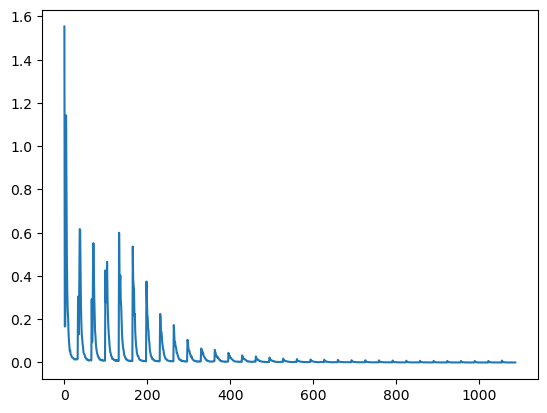

In [21]:
plt.plot((img_spec_anal_params).std(axis=0))

In [22]:
np.save('img_spec_params_std.npy', (img_spec_anal_params).std(axis=0))

# Get global 

Global solution

$s_i = (\phi^\dagger Y^T Y \phi)_{ii}$

(n_bf x N^2) (N^2 x n_img) (n_img x N^2) (N^2 x n_bf)

In [23]:
img_spec_anal_params.shape

(856, 1089)

/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-5.0, 400.0)

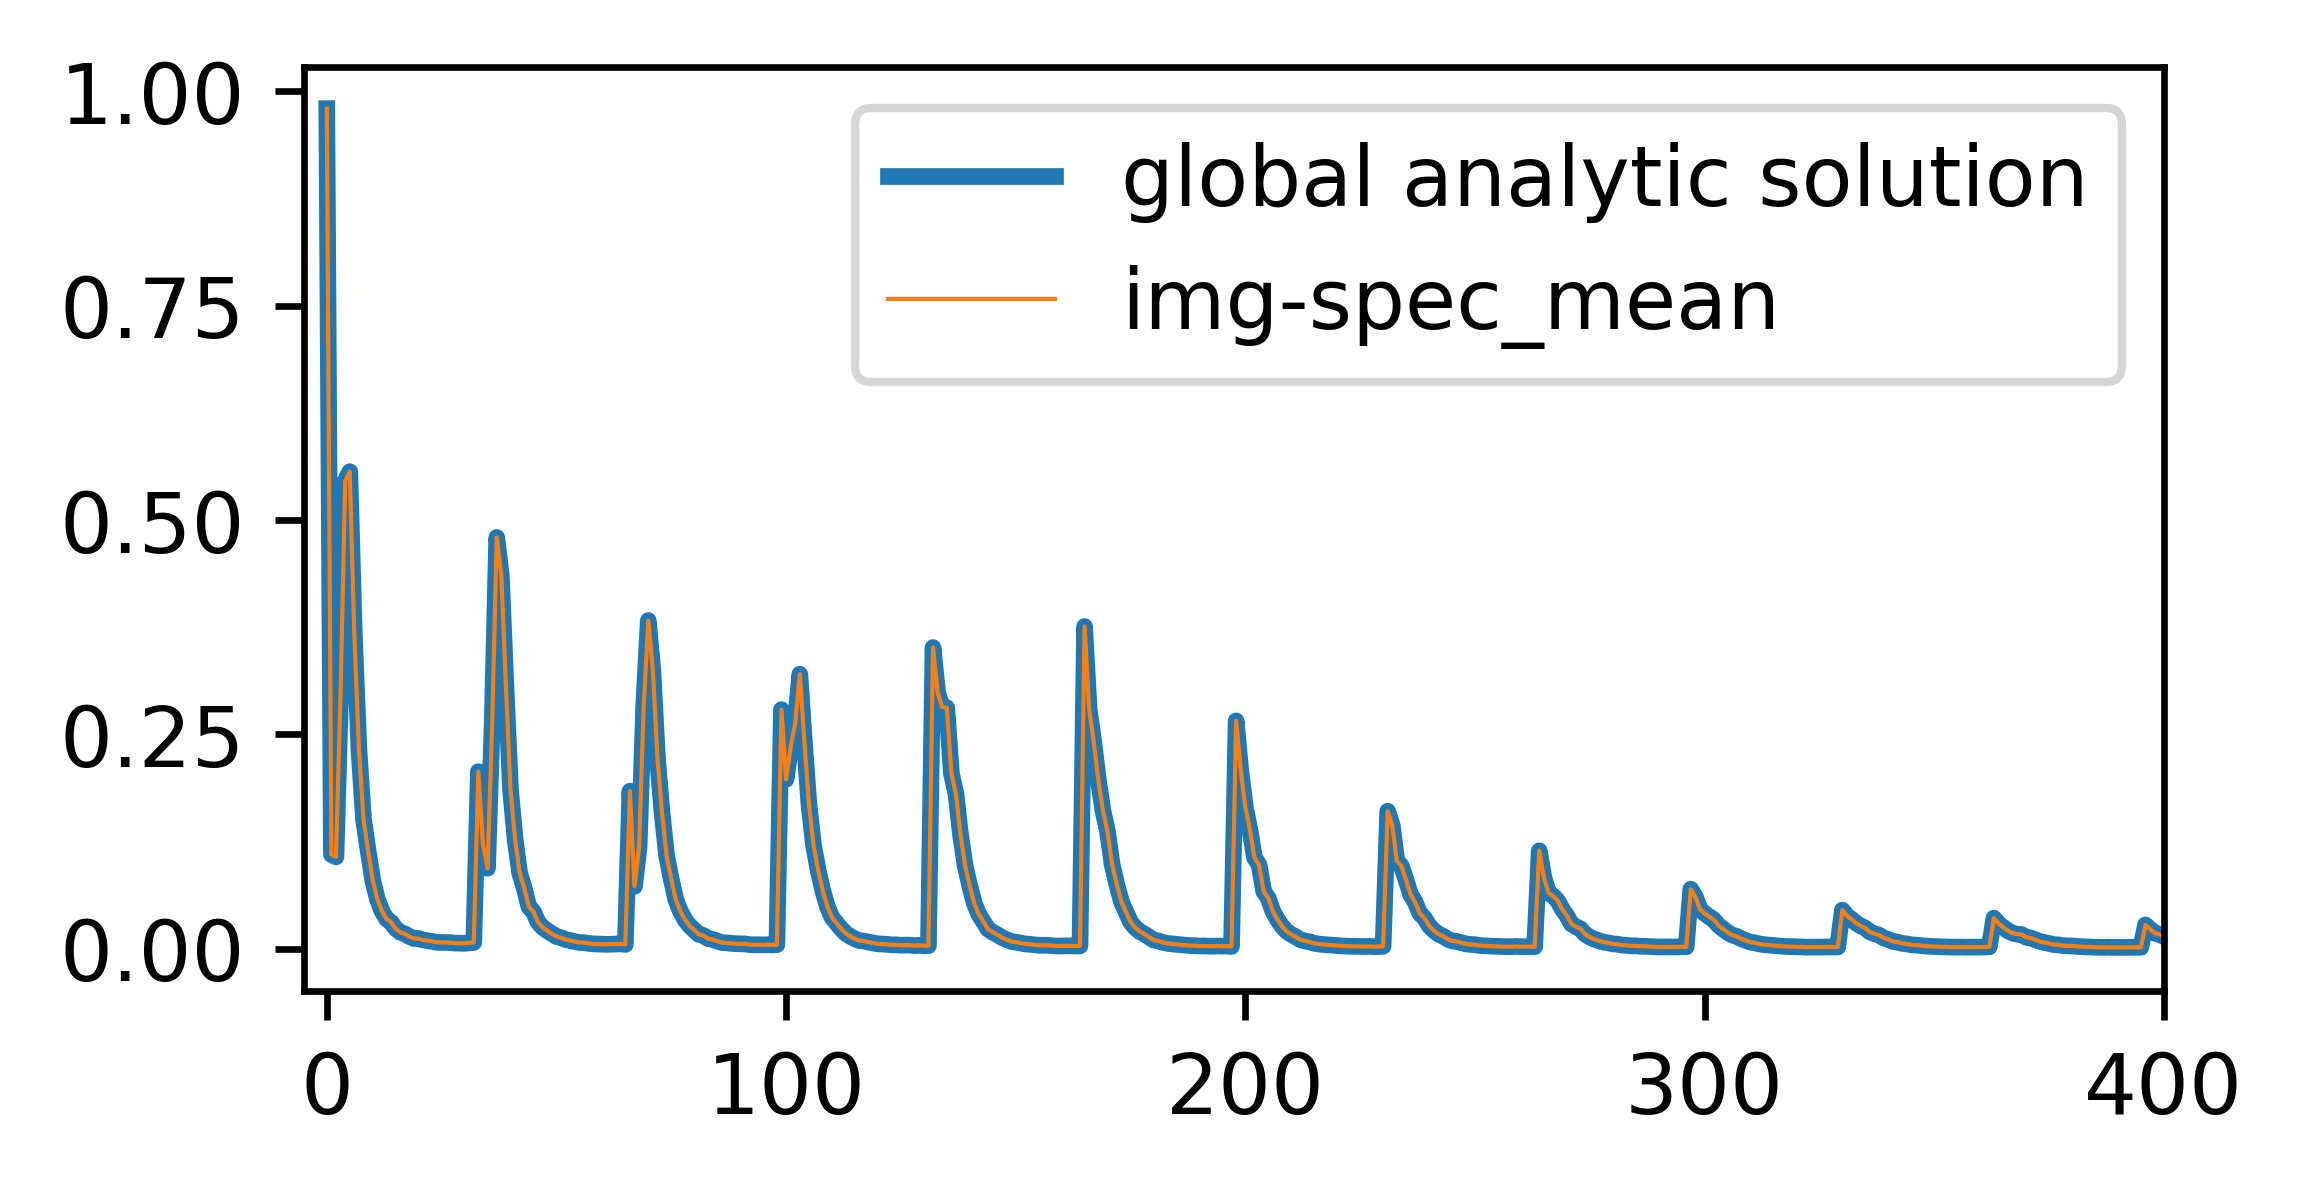

In [24]:
g_A = (
    np.matmul(
        np.matmul(
            np.matmul(
                np.conj(basis_functions.T/N),
                mse_error_fields.reshape(856, N**2).T
                ), 
            mse_error_fields.reshape(856, N**2)
            ), 
        (basis_functions/N)
        )
    )

mse_g_anal_params = np.diag(g_A) / 856

plt.figure(dpi=600, figsize=(4, 2))
plt.plot(mse_g_anal_params, lw=2, label='global analytic solution')
plt.plot(
    img_spec_anal_params.mean(axis=0), 
    lw=0.5, 
    # color='lightgray', 
    label='img-spec_mean')
plt.legend()
plt.xlim(-5, 400)

In [25]:
np.save('anal_sln_global_params.npy', mse_g_anal_params)